In [1]:
import glob
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
import os
import pandas as pd
import pickle
import re

import sys
sys.path.append('/Users/zeynepenkavi/Documents/RangelLab/DescribedVsLearned_fmri/analysis/01_level1')
from level1_utils import run_level1, make_level1_design_matrix, get_events

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/'
behavior_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/behavioral_data/all_trials.csv'

subnum = '01'
runnum='4'

to_filter = ['trans', 'rot', 'drift', 'framewise', 'scrub', 'constant', 'dvars']

A 'modulation' column was found in the given events data and is used.


/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


,choiceShift_st,fractalProb_ev,fractalProb_par,reward_ev,reward_par,rpeLeftFractal_par,rpeRightFractal_par,rpe_par,stim_ev,stim_rt,valDiffFractalWeighted_par,valDiffLotteryWeighted_par
choiceShift_st,1.000000,0.590639,0.458343,0.757393,0.362716,0.245127,0.338215,0.075525,0.970147,-0.509187,-0.141746,-0.005009
fractalProb_ev,0.590639,1.000000,0.752487,0.027088,0.004364,0.016880,0.018745,0.003020,0.713512,-0.357944,-0.103067,-0.002169
fractalProb_par,0.458343,0.752487,1.000000,0.041661,-0.089705,-0.002352,0.046448,0.022341,0.535252,-0.381522,-0.179122,0.051852
reward_ev,0.757393,0.027088,0.041661,1.000000,0.476343,0.321235,0.446949,0.096898,0.645766,-0.404269,-0.105765,-0.004049
reward_par,0.362716,0.004364,-0.089705,0.476343,1.000000,0.299910,0.203577,0.826082,0.299403,-0.089120,0.034880,0.087132
rpeLeftFractal_par,0.245127,0.016880,-0.002352,0.321235,0.299910,1.000000,0.040621,0.134620,0.216599,-0.172457,0.314944,0.110257
rpeRightFractal_par,0.338215,0.018745,0.046448,0.446949,0.203577,0.040621,1.000000,0.045244,0.295170,-0.219955,-0.517472,-0.109341
rpe_par,0.075525,0.003020,0.022341,0.096898,0.826082,0.134620,0.045244,1.000000,0.059847,0.009312,0.038242,-0.032006
stim_ev,0.970147,0.713512,0.535252,0.645766,0.299403,0.216599,0.295170,0.059847,1.000000,-0.502437,-0.145900,-0.006744
stim_rt,-0.509187,-0.357944,-0.381522,-0.404269,-0.089120,-0.172457,-0.219955,0.009312,-0.502437,1.000000,0.181665,-0.016319


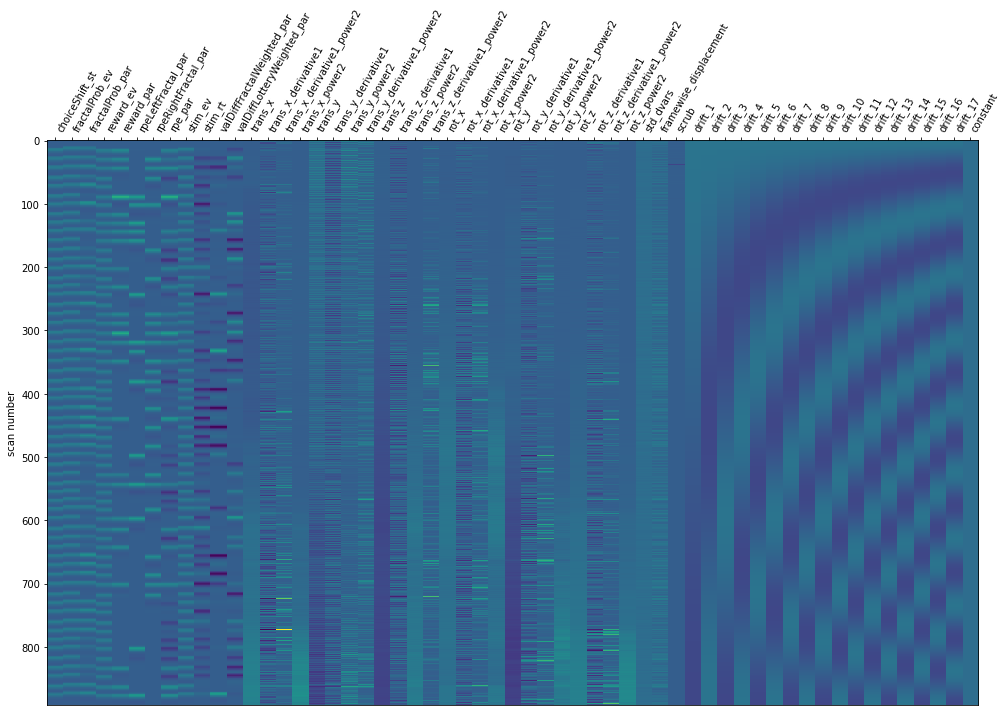

In [4]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model10a', data_path, behavior_path, regress_rt = 1)
plot_design_matrix(design_matrix)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model1', data_path, behavior_path, regress_rt = 0)
plot_design_matrix(design_matrix)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model1a', data_path, behavior_path, regress_rt = 0)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model1', data_path, behavior_path, regress_rt = 1)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model1a', data_path, behavior_path, regress_rt = 1)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix = make_level1_design_matrix(subnum, runnum, 'model2', data_path, behavior_path, regress_rt = 0)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model2', data_path, behavior_path, regress_rt = 1)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model3', data_path, behavior_path, regress_rt = 0)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model3', data_path, behavior_path, regress_rt = 1)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model4', data_path, behavior_path, regress_rt = 0)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model4', data_path, behavior_path, regress_rt = 1)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model5', data_path, behavior_path, regress_rt = 0)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model5', data_path, behavior_path, regress_rt = 1)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model6', data_path, behavior_path, regress_rt = 0)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
design_matrix= make_level1_design_matrix(subnum, runnum, 'model6', data_path, behavior_path, regress_rt = 1)
beh_regs = design_matrix.columns
beh_regs = [x for x in beh_regs if all(y not in x for y in to_filter)]
design_matrix[beh_regs].corr()

In [ ]:
mnum = 'model1'
reg_rt = 1
out_path = os.path.join(data_path, "derivatives/nilearn/glm/level1/%s_reg-rt%s")%(mnum, str(reg_rt)

# run_level1(subnum, mnum, data_path, behavior_path, out_path, regress_rt = reg_rt)

In [ ]:
mnum = 'model2'
reg_rt = 0
out_path = os.path.join(data_path, "derivatives/nilearn/glm/level1/%s_reg-rt%s")%(mnum, str(reg_rt))
                                                                                
# run_level1(subnum, 'model2', data_path, behavior_path, out_path, regress_rt = 0)